## Load libraries

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1) 
 
# Matplotlib for plotting
%matplotlib inline
import matplotlib.pyplot as plt

# pickle in case you don't have REFPROP installed
import pickle as pkl
run_refprop = False

### Set some convient defaults for plotting
Note these need to be set after and in a separate code block from `%matplotlib inline`

In [2]:
plt.rcParams['figure.figsize'] = [16.5, 12]
plt.rcParams['figure.titlesize'] = 'xx-large'
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['axes.grid'] = True

### Define some standard terms, so that columns are consistent
This is all done in __[markdown](https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed)__, taking advantage of __[MathJax](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Typesetting%20Equations.html)__

In [3]:
p = '$p$ / kPa'
T = '$T$ / K'
xC3 = '$x_{\mathrm{C}_3\mathrm{H}_8}$'  # Here, we've used the notation that x = liquid, y = vapor
yC3 = '$y_{\mathrm{C}_3\mathrm{H}_8}$'  # This nomenclature is not consistent across disciplines.
rho = '$\\rho$ / $\mathrm{kg}\\cdot\mathrm{m}^{-3}$'
Vfrac = '$V_\mathrm{L} / V$'

source = 'Source'
rejected = 'Rejected?'
smoothed = 'Smoothed?'
comment = 'Comment'

## Read in Data and Examine

In [4]:
xl = pd.ExcelFile('H2S-C3H8-data.xlsx')
pdd = {}
plot_kw = {}
for name in xl.sheet_names:
    pdd[name] = xl.parse(name,skiprows=2)
    if 'COMMENT' in pdd[name].columns:
        pdd[name] = pdd[name].rename(columns={'COMMENT':comment})
    if 'Smoothed data?' in pdd[name].columns:
        pdd[name] = pdd[name].rename(columns={'Smoothed data?':smoothed})
    if 'Set' in pdd[name].columns:
        pdd[name] = pdd[name].rename(columns={'Set':rejected})
    for col in (smoothed, rejected):
        if col in pdd[name].columns:
             pdd[name][col] = ~pdd[name][col].isnull();
    print(name)
    print(pdd[name].head())

    for src in pdd[name][source]:
        plot_kw[src] = {}

azeotropic P
   #        Source  Rejected?  Smoothed?  Temperature / K  \
0  1  1950 ram & 0  False      True       280.979           
1  2  1950 ram & 0  False      True       297.636           
2  3  1950 ram & 0  False      True       310.242           
3  4  1950 ram & 0  False      True       320.683           
4  5  1950 ram & 0  False      True       329.569           

   Azeotropic pressure/ kPa Comment  
0  1378.95                   NaN     
1  2068.43                   NaN     
2  2757.90                   NaN     
3  3447.38                   NaN     
4  4136.85                   NaN     
x azeotrope
   #        Source  Rejected?  Smoothed?  Temperature / K  \
0  1  1950 ram & 0  False      True       280.979           
1  2  1950 ram & 0  False      True       297.636           
2  3  1950 ram & 0  False      True       310.242           
3  4  1950 ram & 0  False      True       320.683           
4  5  1950 ram & 0  False      True       329.569           

   Azeotropic

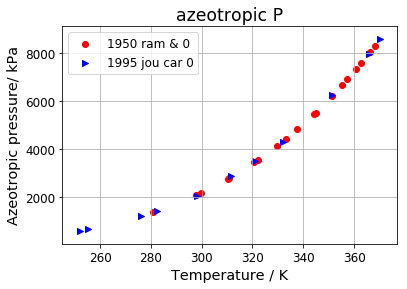

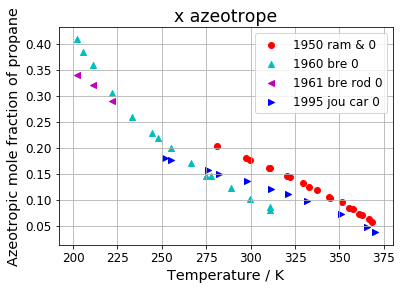

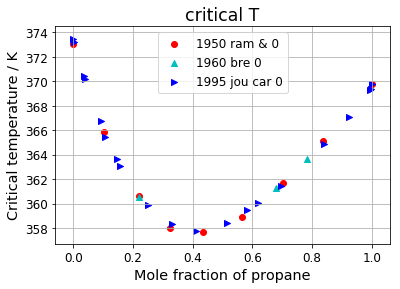

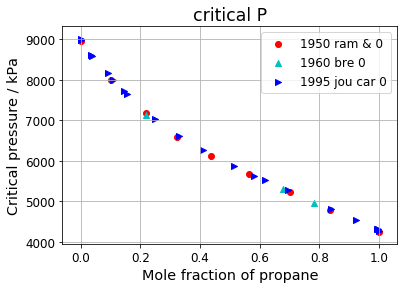

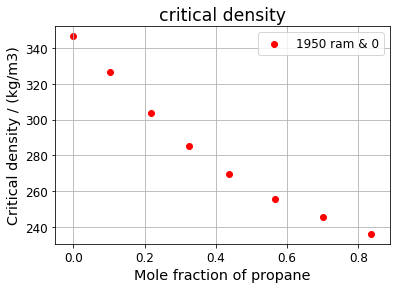

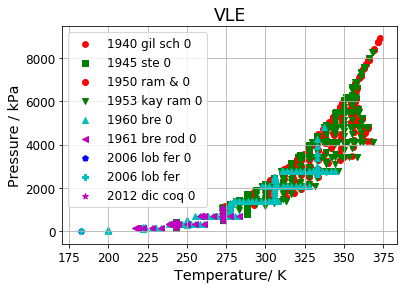

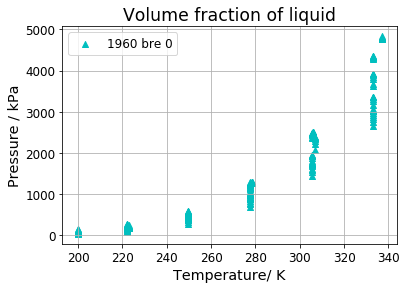

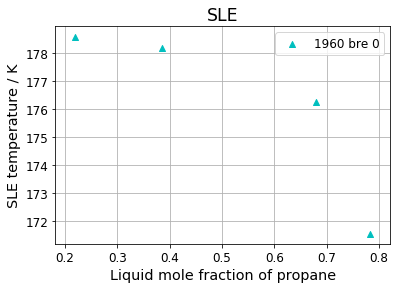

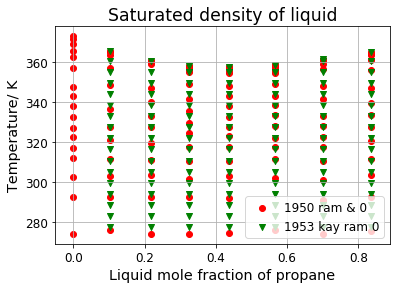

In [5]:
markers = ['o', 'v', '>', '^', '<', '8', 's', 'p', 'P', '*', 'h', 'H', 'x', 'D']
colors  = ['r', 'g', 'b', 'c', 'm']
for (i, src) in zip (np.arange(0,len(plot_kw)), plot_kw):
    plot_kw[src]['c'] = colors[i % len(colors)]
    plot_kw[src]['marker'] = markers[i % len(markers)]
    plot_kw[src]['label'] = src

plots = [['azeotropic P', 'Temperature / K', 'Azeotropic pressure/ kPa'],
         ['x azeotrope',  'Temperature / K', 'Azeotropic mole fraction of propane'],    
         ['critical T',  'Mole fraction of propane', 'Critical temperature / K'],    
         ['critical P',  'Mole fraction of propane', 'Critical pressure / kPa'],    
         ['critical density',  'Mole fraction of propane', 'Critical density / (kg/m3)'],    
         ['VLE',  'Temperature/ K', 'Pressure / kPa'],    
         ['Volume fraction of liquid',  'Temperature/ K', 'Pressure / kPa'],    
         ['SLE',  'Liquid mole fraction of propane', 'SLE temperature / K'],    
         ['Saturated density of liquid',  'Liquid mole fraction of propane', 'Temperature/ K'],    
        ]

def plot_set(df, x=None, y=None, title=None, axes=None):
    if not x:
        x = df.columns[0]
    if not y:
        y = df.columns[1]
    
    if not axes:
        plt.subplots(1,1)
        axes = plt.subplot(1,1,1)

    for src in df[source].unique():
        mask = (df[source]==src) & (df[x].notnull()) & (df[y].notnull())
        if rejected in df.columns:
            mask &= ~df[rejected].astype(bool)
        if len(df[[x,y]][mask]) == 0:
            continue
        if 'marker' in plot_kw[src]:
            axes.scatter(df[x][mask],
                         df[y][mask],
                         **plot_kw[src]
                    )
        else:
            axes.plot(df[x][mask],
                      df[y][mask],
                      **plot_kw[src]
                    )
    
    if title:
        axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)
    axes.legend()

old_size = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [6, 4]
for (title, x, y) in plots:
    plot_set(pdd[title], x, y, title)
plt.show()
plt.rcParams['figure.figsize'] = old_size

Implement minor corrections

Full citations available from [NIST ThermoLit](https://trc.nist.gov/thermolit)
https://trc.nist.gov/thermolit/main/home.html#property/syssel:2:info;propane:info;hydrogen_sulfide:form/props:1:0:0
https://trc.nist.gov/thermolit/main/home.html#property/syssel:2:info;propane:info;hydrogen_sulfide:form/props:5:0:0

In [6]:
ref_fixes = {'1940 gil sch 0': '1940 Gilliland & Scheeline',
             '1945 ste 0':     '1945 Steckel',
             '1950 ram & 0':   '1950 Rambosek',
             '1953 kay ram 0': '1953 Kay & Rambosek',
             '1960 bre 0':     '1960 Brewer',
             '1961 bre rod 0': '1961 Brewer et al.',
             '1965 rob jac 0': '1965 Robinson & Jacoby',
             '1995 jou car 0': '1995 Jou et al.',
             '2006 lob fer 0': '1961 Lobo et al.',
             '2006 lob fer':   '1961 Lobo et al.',
             '2011 jar riv 0': '2011 Jarne et al.',
             '2012 dic coq 0': '2012 Dicko et al.'             
            }
for src in ref_fixes:
    plot_kw[ref_fixes[src]] = plot_kw[src]
    plot_kw[src]['label'] = ref_fixes[src]
    for k in pdd:
        pdd[k].loc[pdd[k][source]==src, source] = ref_fixes[src]

### Format and plot azeotrope data

In [7]:
az_df = pdd['azeotropic P'].drop(columns='#').merge(pdd['x azeotrope'].drop(columns='#'),how='outer')
az_df = az_df.rename(columns={'Temperature / K':T,
                              'Azeotropic pressure/ kPa':p,
                              'Azeotropic mole fraction of propane':xC3})
az_df = az_df[az_df.columns[[0,3,4,6,1,2,5]]]

def color_row(row, color='LightCoral', field=rejected, value=True):
    '''
    Reformat a row based upon certain values.
    '''
    attr = 'color: {}'.format(color)
    return [attr if row[field] == value else ''] * len(row)

def color_nan(value, color='lightgray'):
    '''
    Reformat a cell based upon a certain value.
    '''
    attr = 'color: {}'.format(color)
    return attr if type(value) == float and np.isnan(value) else ''

az_df.style.apply(color_row, axis=1). \
            applymap(color_nan).      \
            format({T: '{:0.2f}',p: '{:0.4g}',xC3: '{:0.3f}'})

,Source,$T$ / K,$p$ / kPa,$x_{\mathrm{C}_3\mathrm{H}_8}$,Rejected?,Smoothed?,Comment
0,1950 Rambosek,280.98,1379,0.203,False,True,nan
1,1950 Rambosek,297.64,2068,0.180,False,True,nan
2,1950 Rambosek,310.24,2758,0.161,False,True,nan
3,1950 Rambosek,320.68,3447,0.145,False,True,nan
4,1950 Rambosek,329.57,4137,0.132,False,True,nan
5,1950 Rambosek,337.57,4826,0.119,False,True,nan
6,1950 Rambosek,344.90,5516,0.102,False,True,nan
7,1950 Rambosek,351.35,6205,0.096,False,True,nan
8,1950 Rambosek,357.40,6895,0.082,False,True,nan
9,1950 Rambosek,362.90,7584,0.070,False,True,nan


C:\Users\kennethk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kennethk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


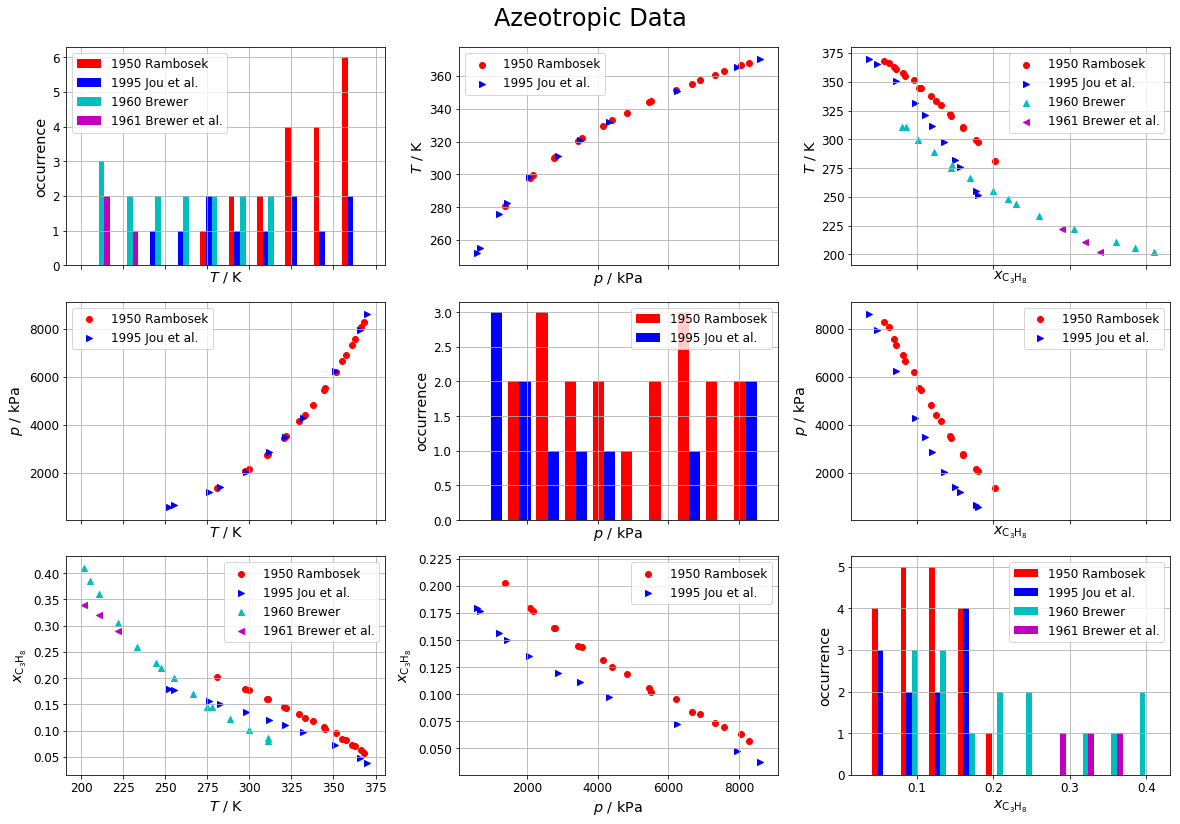

In [8]:
def hist_set(df, prop=None, title=None, axes=None):
    if not prop:
        prop = df.columns[0]
    
    if not axes:
        plt.subplots(1,1)
        axes = plt.subplot(1,1,1)

    sources = df[source].unique()
    x = pd.DataFrame()
    for src in sources:
        mask = df[source]==src
        if rejected in df.columns:
            mask &= ~df[rejected].astype(bool)
        target = df[prop][mask].dropna()
        if len(target) == 0 or 'marker' not in plot_kw[src]:
            sources = np.delete(sources, np.where(sources == src), axis=0)
            continue
        x = pd.concat([x, target], ignore_index=True, axis=1)
    
    axes.hist(x.transpose(), color=list(map(lambda src: plot_kw[src]['c'], sources)), label=sources)
    
    if title:
        axes.set_title(title)
    axes.set_xlabel(prop)
    axes.set_ylabel("occurrence")
    axes.legend()

def plot_grid(df, columns, title=None):
    n = len(columns)
    fig, axes = plt.subplots(n,n, sharex='col')
    for i in np.arange(n):
        for j in np.arange(n):
#             if (i < j):
#                 axes[i,j].axis('off')
#                 continue
            if (i == j):
                hist_set(df, columns[i], axes=axes[i,i])
            else:
                plot_set(df, columns[j], columns[i], axes=axes[i,j])
    if title:
        fig.suptitle(title, fontsize=24)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# np.warnings.filterwarnings('ignore')
plot_grid(az_df, az_df.columns[[1,2,3]], title='Azeotropic Data')

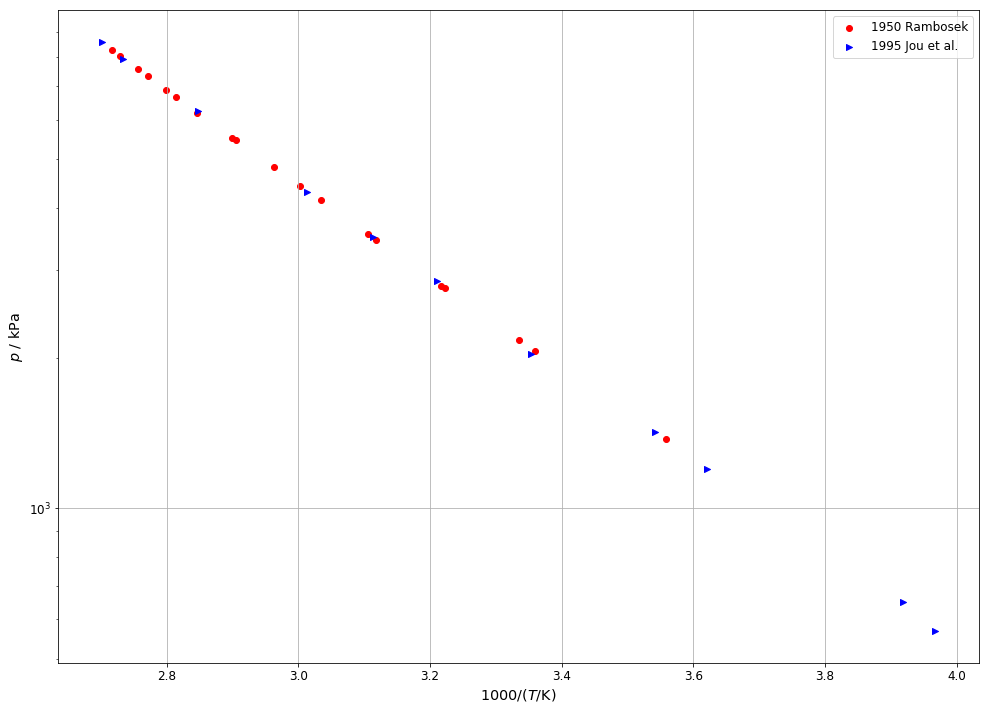

In [9]:
# And generate a classic Arrhenius plot while we are at it
def arrhenius (source_df, title=None, axes=None):
    '''
    Assume that T and p are x & y
    '''    
    if not axes:
        plt.subplots(1,1)
        axes = plt.subplot(1,1,1)

    Tinv = '$ 1000 / (T / \mathrm{K}) $'
    df = source_df.copy();
    df[Tinv] = 1000/df[T]
    axes.semilogy()
    
    plot_set(df,x=Tinv,y=p, title=title, axes=axes)

arrhenius(az_df)

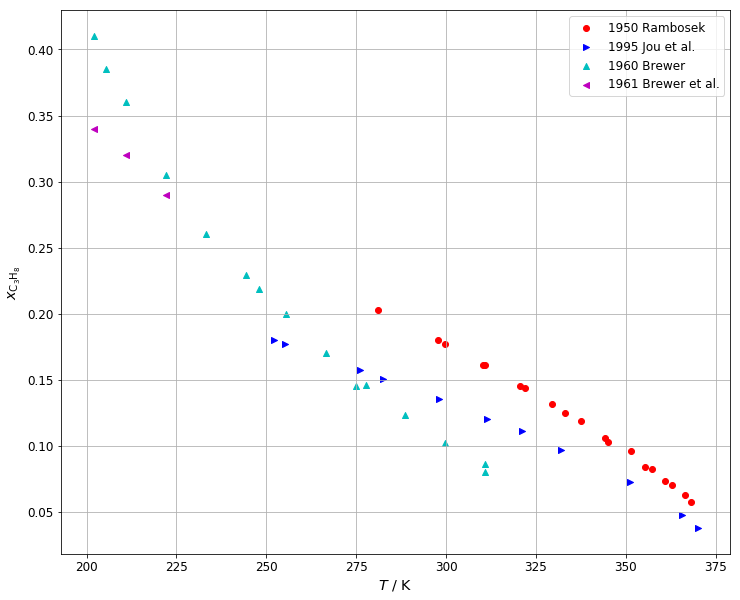

In [10]:
plt.subplots(1,1, figsize=(12, 10))
plot_set(az_df,x=T,y=xC3,axes=plt.subplot(1,1,1))

### Format and plot critical data

In [11]:
crit_df = pdd['critical T'].drop(columns='#').merge(pdd['critical P'].drop(columns='#'),how='outer')  \
          .merge(pdd['critical density'].drop(columns='#'),how='outer')
crit_df = crit_df.rename(columns={'Mole fraction of propane':xC3,
                                  'Critical temperature / K':T,
                                  'Critical pressure / kPa':p,
                                  'Critical density / (kg/m3)':rho})
crit_df = crit_df[crit_df.columns[[0,2,3,5,6,1,4]]]
crit_df.style.apply(color_row, axis=1).                             \
              applymap(color_nan).                                  \
              set_properties(subset=[rho], **{'width': '8em'}).     \
              format({T: '{:0.2f}',p: '{:0.4g}',xC3: '{:0.3f}', rho: '{:0.2f}'})

,Source,$x_{\mathrm{C}_3\mathrm{H}_8}$,$T$ / K,$p$ / kPa,$\rho$ / $\mathrm{kg}\cdot\mathrm{m}^{-3}$,Rejected?,Comment
0,1950 Rambosek,0.000,373.05,8943,346.48,False,nan
1,1950 Rambosek,0.102,365.87,7994,326.78,False,nan
2,1950 Rambosek,0.218,360.59,7172,303.55,False,nan
3,1950 Rambosek,0.325,358.02,6593,285.13,False,nan
4,1950 Rambosek,0.436,357.71,6120,269.91,False,nan
5,1950 Rambosek,0.566,358.87,5665,255.66,False,nan
6,1950 Rambosek,0.701,361.65,5234,245.88,False,nan
7,1950 Rambosek,0.837,365.15,4792,236.27,False,nan
8,1950 Rambosek,1.000,369.79,4249,nan,False,nan
9,1953 Kay & Rambosek,0.000,373.05,8943,346.48,True,Duplicate of 1950 ram 0 (dissertation) - exact match


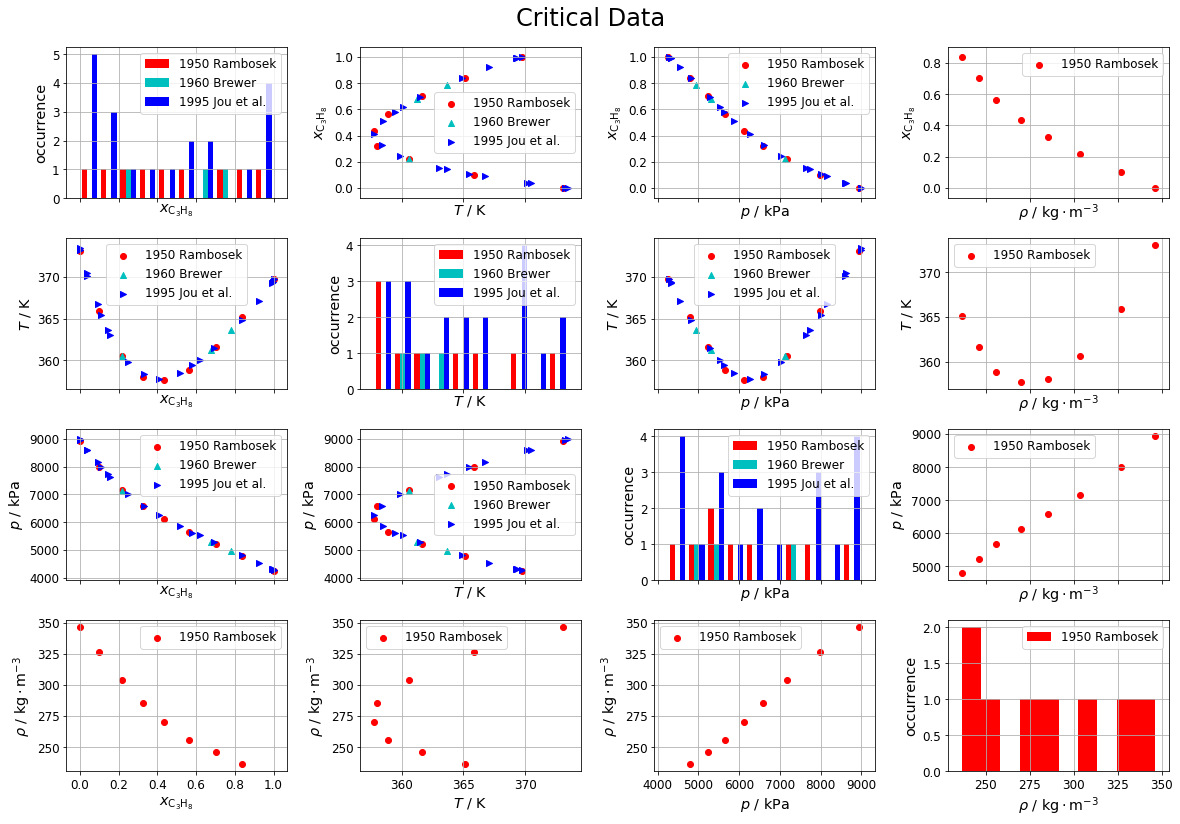

In [12]:
plot_grid(crit_df, crit_df.columns[[1,2,3,4]], title='Critical Data')

### Vapor-Liquid Equilibrium

In [13]:
VLE_df = pdd['VLE'].drop(columns='#')
VLE_df = VLE_df.rename(columns={'Liquid mole fraction of propane':xC3,
                                'Temperature/ K':T,
                                'Gas mole fraction of propane':yC3,
                                'Pressure / kPa':p,
                               })
VLE_df = VLE_df[VLE_df.columns[[0,5,3,2,4,1,6,7]]]
VLE_df.style.apply(color_row, axis=1).                             \
              applymap(color_nan).                                  \
              format({T: '{:0.2f}',p: '{:0.4g}',xC3: '{:0.3f}', xC3: '{:0.3f}'})

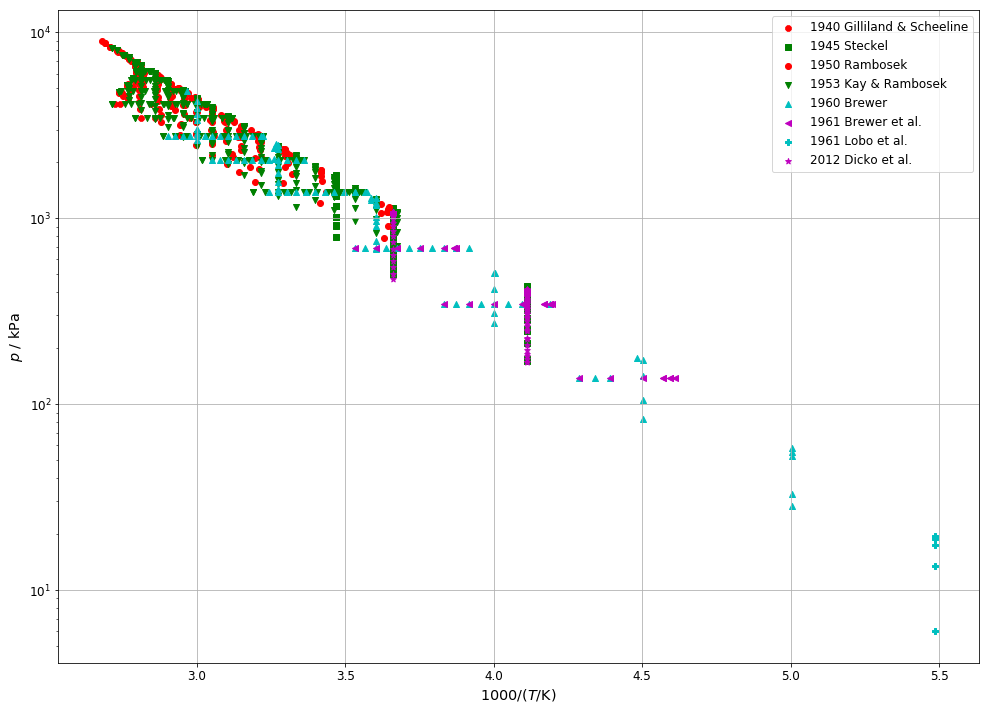

In [14]:
arrhenius(VLE_df)

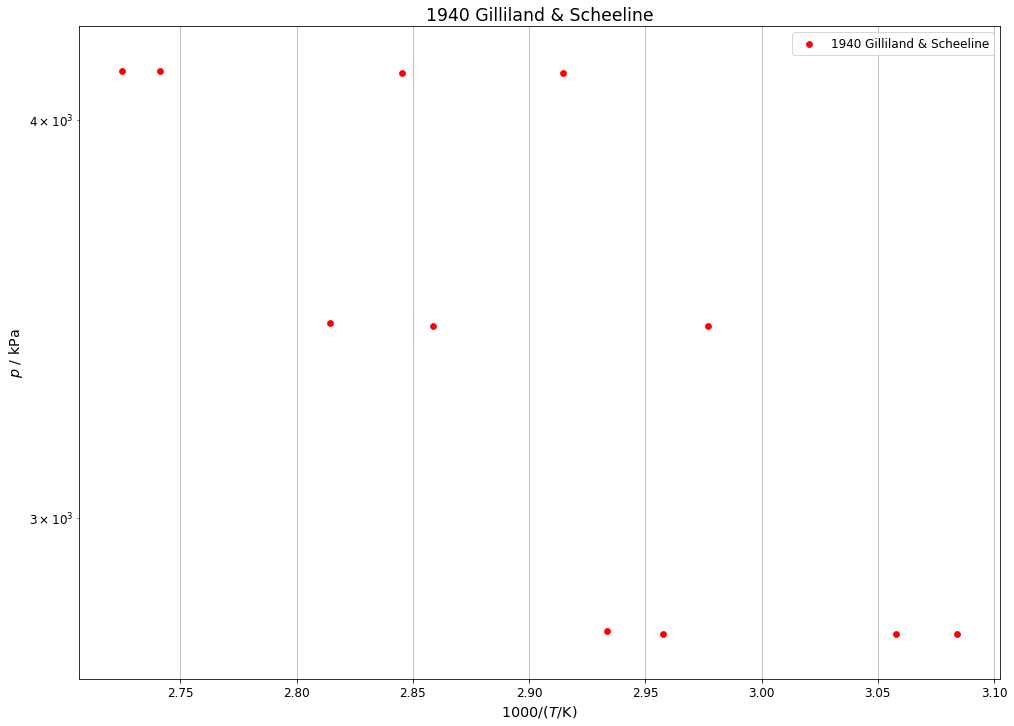

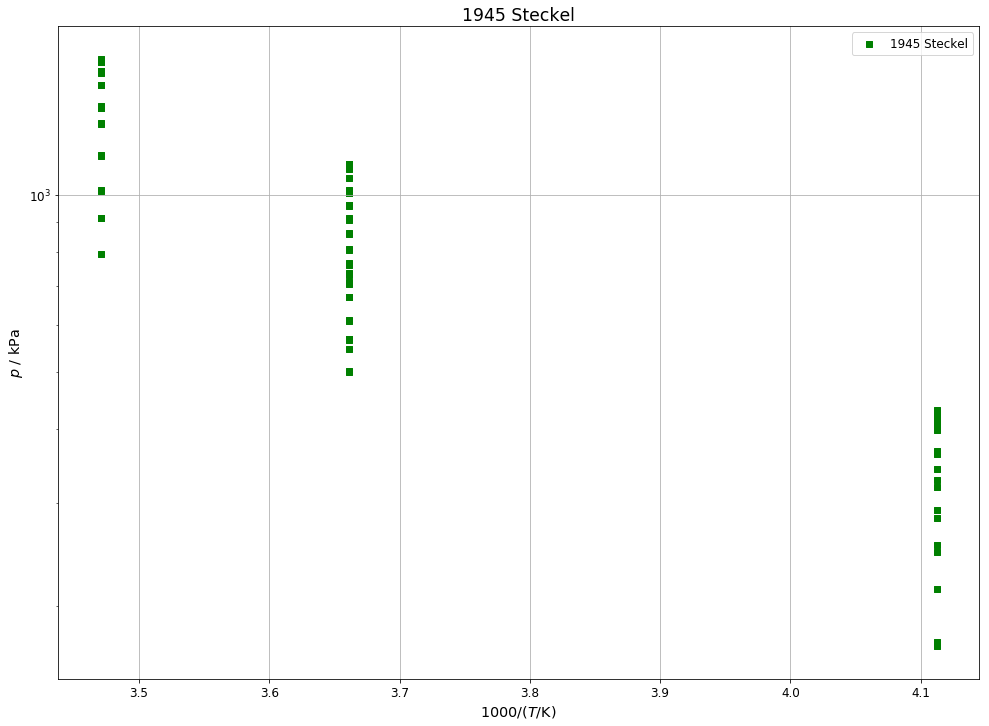

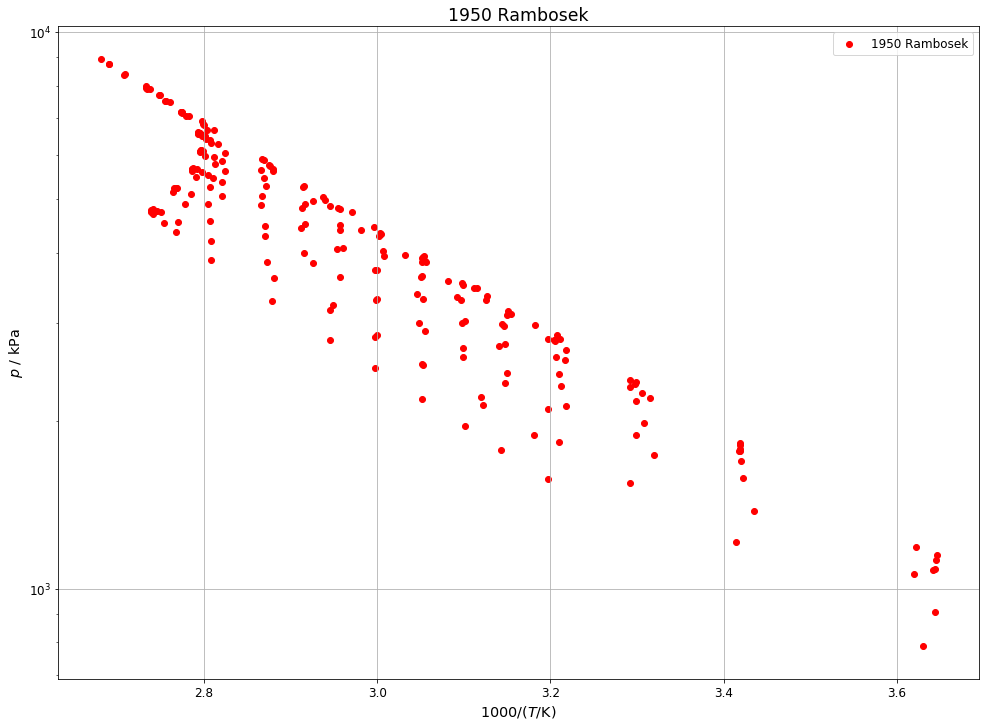

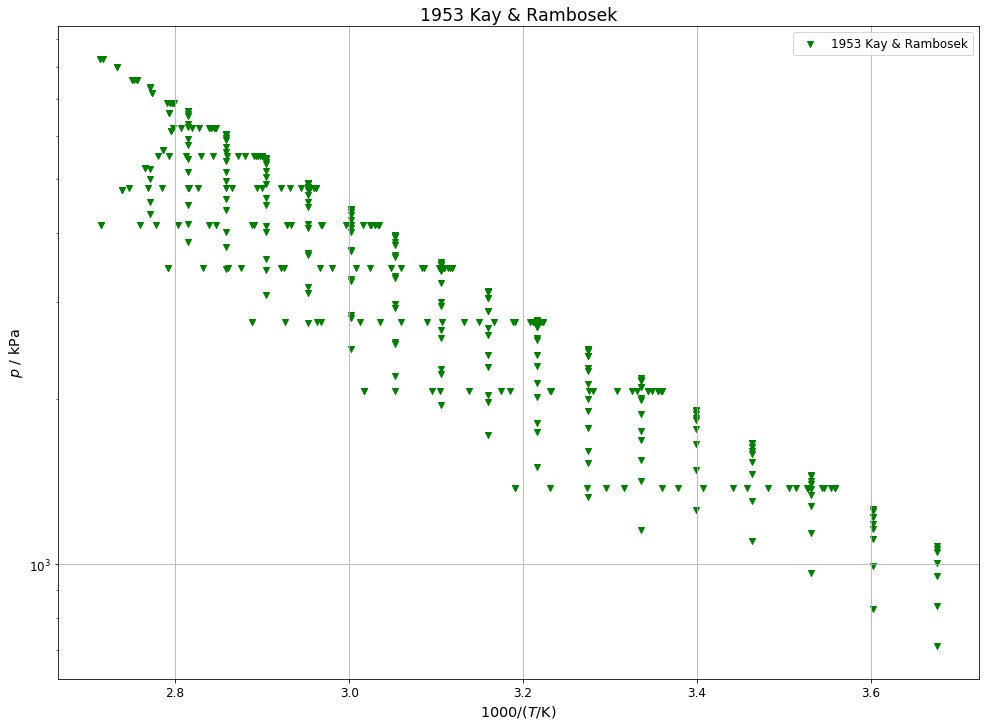

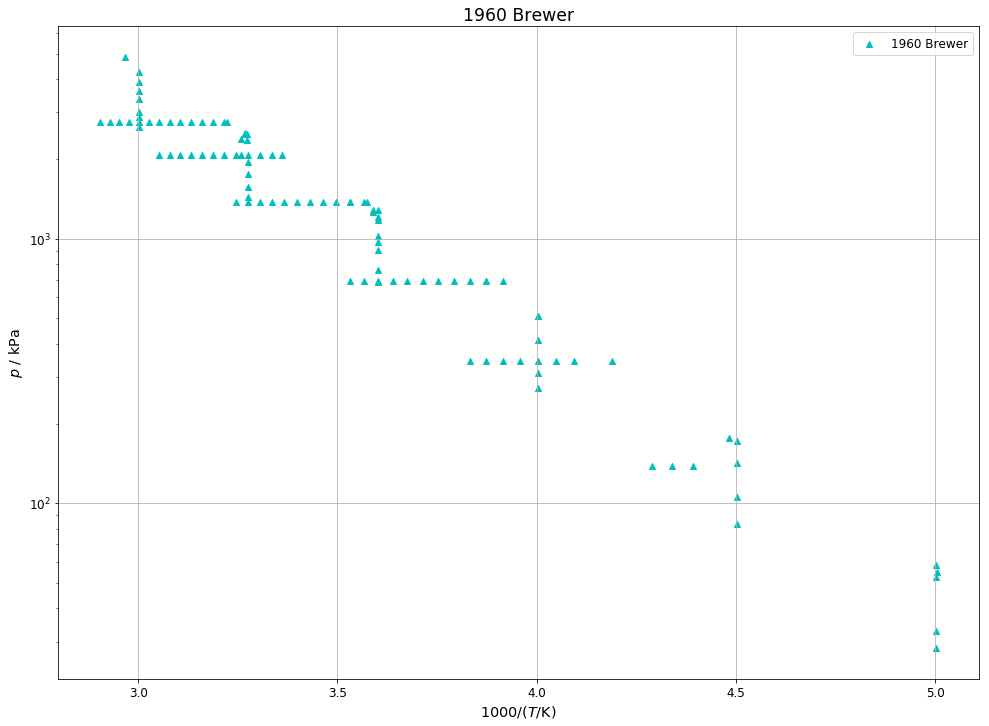

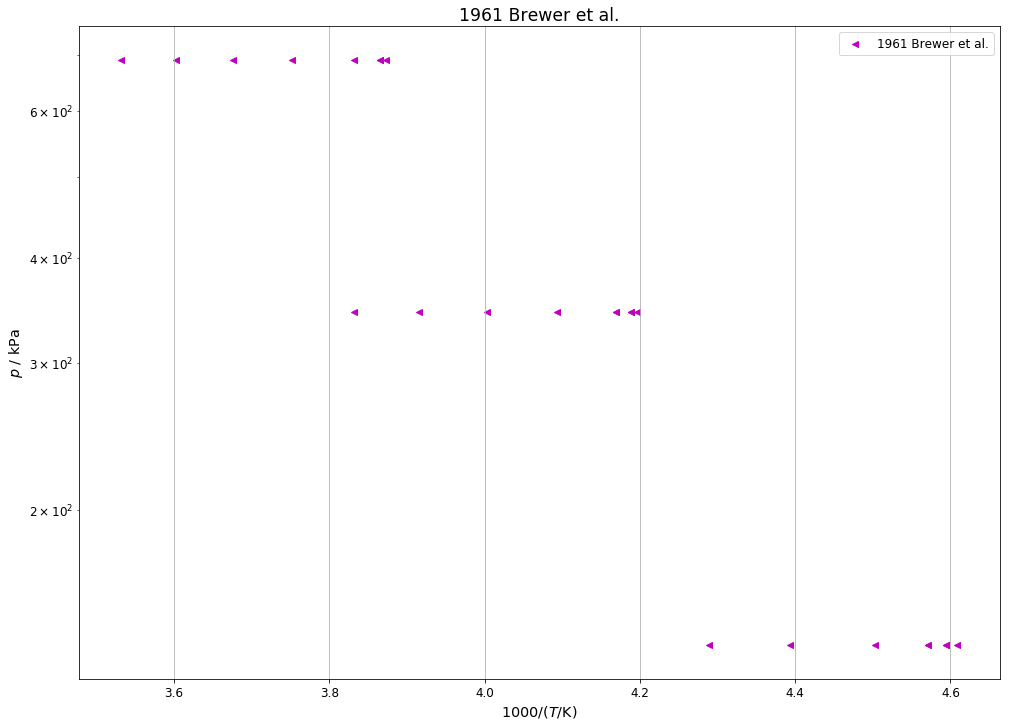

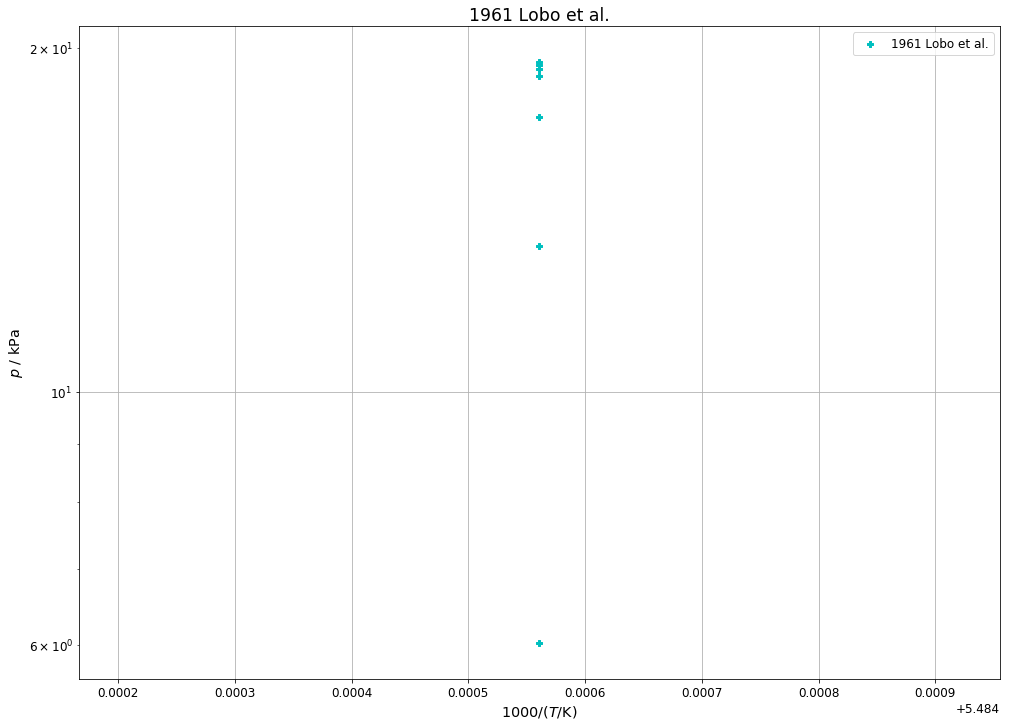

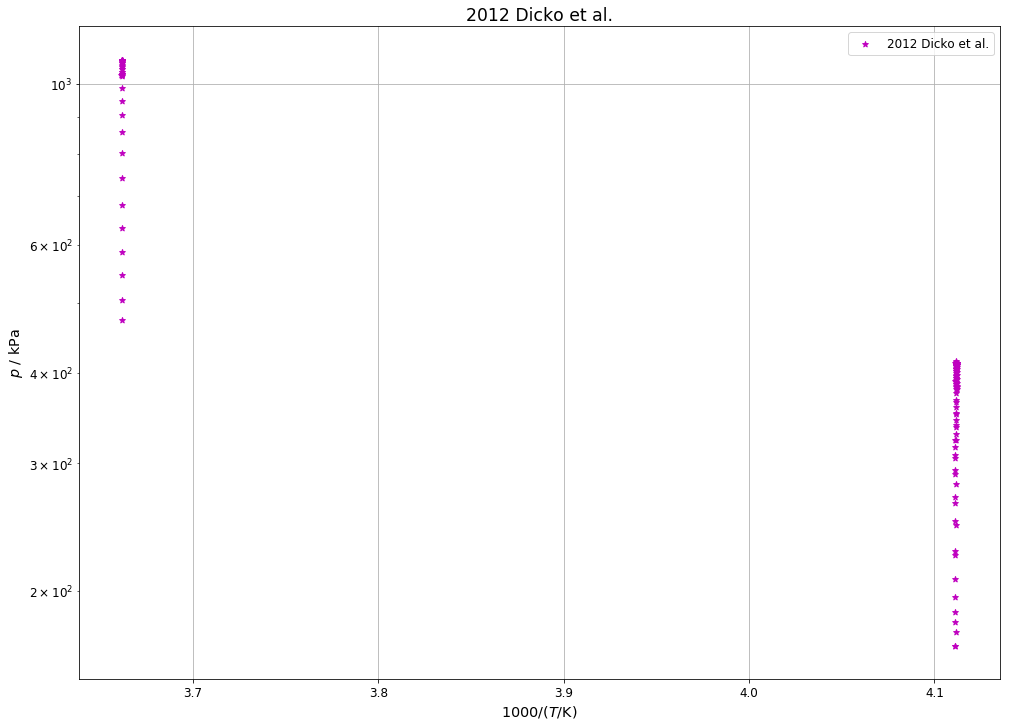

In [15]:
for src in VLE_df[source].unique():
    arrhenius(VLE_df[VLE_df[source]==src], title=src)

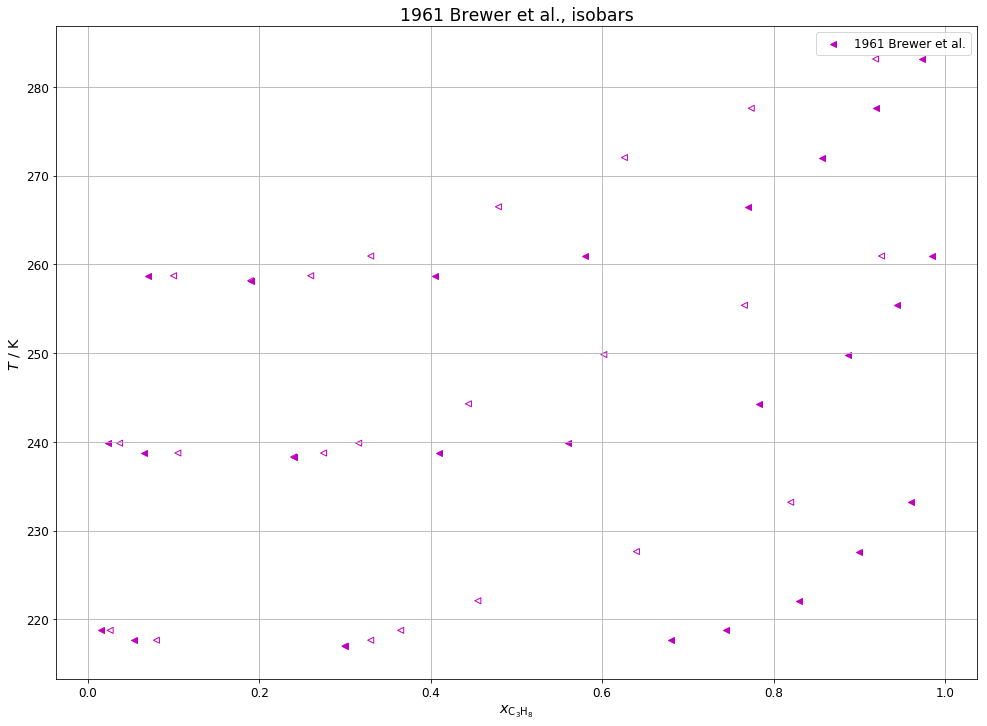

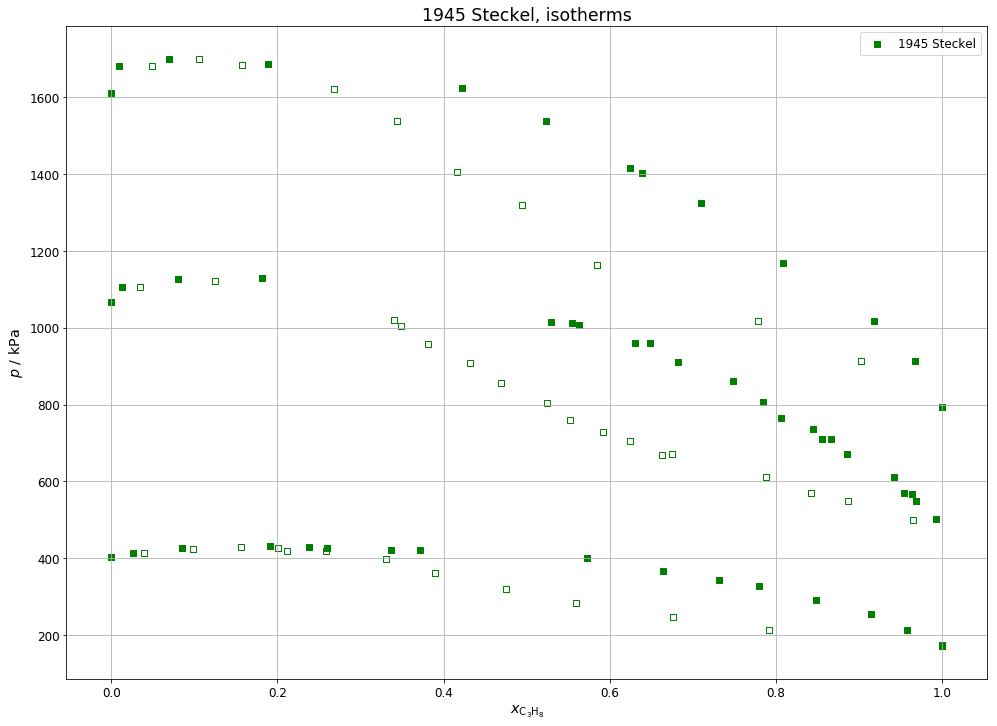

In [67]:
def VLE_plot_set(df, prop, title=None, axes=None, lines=None):
    if lines == None:
        lines = 'Set' in df.columns
        
    if not axes:
        plt.subplots(1,1)
        axes = plt.subplot(1,1,1)

    # Process in blocks of citations and sets, if sets are present
    for src in df[source].unique():
        # Basic requirements
        base_mask = (df[source]==src) & (df[prop].notnull())
        if rejected in df.columns:
            base_mask &= ~df[rejected].astype(bool)
        
        # Bin by sets if present
        if 'Set' in df.columns:
            masks = [base_mask & (df['Set']==i) for i in df['Set'].unique()]
        else:
            masks = [base_mask]
        
        # Build up plotting preferences, xm_kw -> x, marker keywords
        seen_legend = False
        xm_kw = {**plot_kw[src]}
        xl_kw = {**plot_kw[src], 'ls': '-'}
        xl_kw.pop('marker',None)
        ym_kw = {**plot_kw[src], 'facecolors':'none', 'edgecolors': plot_kw[src]['c']}
        ym_kw.pop('c',None)
        yl_kw = {**plot_kw[src], 'ls': '--'}
        yl_kw.pop('marker',None)
        
        # Cycle over bins, writing to the legend on only the first loop
        for mask in masks:
            if sum(mask & df[xC3].notnull()) != 0:
                if 'marker' in xm_kw: # Solid symbols for liquid mole fraction
                    if seen_legend:
                        xm_kw['label'] = '__nolegend__'
                    axes.scatter(df[xC3][mask & df[xC3].notnull()],
                                 df[prop][mask & df[xC3].notnull()],
                                 **xm_kw
                            )
                    seen_legend = True

                if lines: # Solid line connecting liquid mole fraction
                    if seen_legend:
                        xl_kw['label'] = '__nolegend__'
                    axes.plot(df[xC3][mask & df[xC3].notnull()],
                              df[prop][mask & df[xC3].notnull()],
                              **xl_kw
                            )
                    seen_legend = True

            if sum(mask & df[yC3].notnull()) != 0:
                if 'marker' in xm_kw: # Hollow symbols for vapor mole fraction
                    if seen_legend:
                        ym_kw['label'] = '__nolegend__'
                    axes.scatter(df[yC3][mask & df[yC3].notnull()],
                                 df[prop][mask & df[yC3].notnull()],
                                 **ym_kw
                            )
                    seen_legend = True

                if lines: # Dashed line connecting vapor mole fraction
                    if seen_legend:
                        yl_kw['label'] = '__nolegend__'
                    axes.plot(df[yC3][mask & df[yC3].notnull()],
                              df[prop][mask & df[yC3].notnull()],
                              **yl_kw
                            )
                    seen_legend = True

    if title:
        axes.set_title(title)
    axes.set_xlabel(xC3)
    axes.set_ylabel(prop)
    axes.legend()
    
# src = '1940 Gilliland & Scheeline'
src = '1961 Brewer et al.'
VLE_plot_set(VLE_df[VLE_df[source]==src],T, title='{}, isobars'.format(src))
src = '1945 Steckel'
VLE_plot_set(VLE_df[VLE_df[source]==src],p, title='{}, isotherms'.format(src))

We need a filter for isotherms (or isobars) from all sources.  We'll choose a default value of minimum point count of 5, since small point count curves will likely be more distracting than useful, and (by default) define an isotherm as a dataset from 1 citation and having a window of .1 K;  and an isobar as having a window of 1 %.

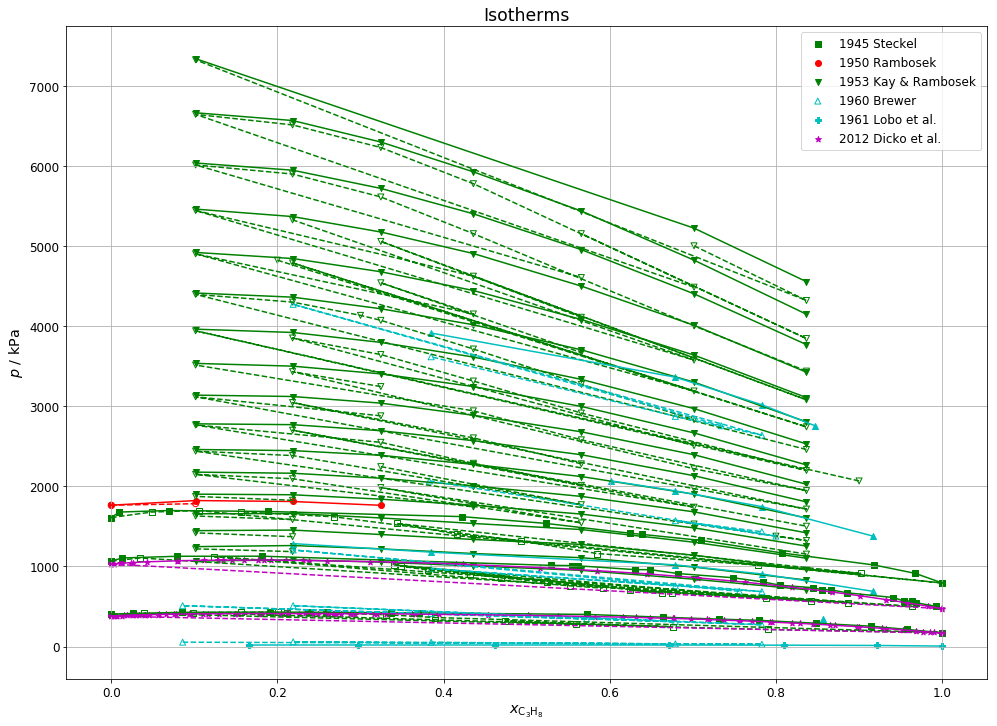

In [68]:
def filter_isotherms(df, tol=.1, n=5):
    '''
    Returns a dataframe that contains isotherms
    '''
    isotherm_df = pd.DataFrame()
    for src in VLE_df[source].unique():
        mask = (VLE_df[source]==src) & (VLE_df[T].notnull()) 
        if rejected in VLE_df.columns:
            mask &= ~VLE_df[rejected].astype(bool)
        subset = VLE_df[mask].sort_values(T)
        i_max = sum(mask)
        i = 0
        cnt = 1
        subset['Set'] = 0
        while i < i_max:
            j = i+1
            while (j < i_max) and (subset[T].iloc[j] - subset[T].iloc[i] < tol):
                j += 1
            if j - i >= n:
                isotherm_df = isotherm_df.append(subset.iloc[i:j].sort_values(xC3), ignore_index=True)
                isotherm_df.loc[i-j+len(isotherm_df):len(isotherm_df),'Set'] = cnt
                cnt += 1
            i = j
    
    return isotherm_df

isotherm_df = filter_isotherms(VLE_df)
VLE_plot_set(isotherm_df,p, title='Isotherms')

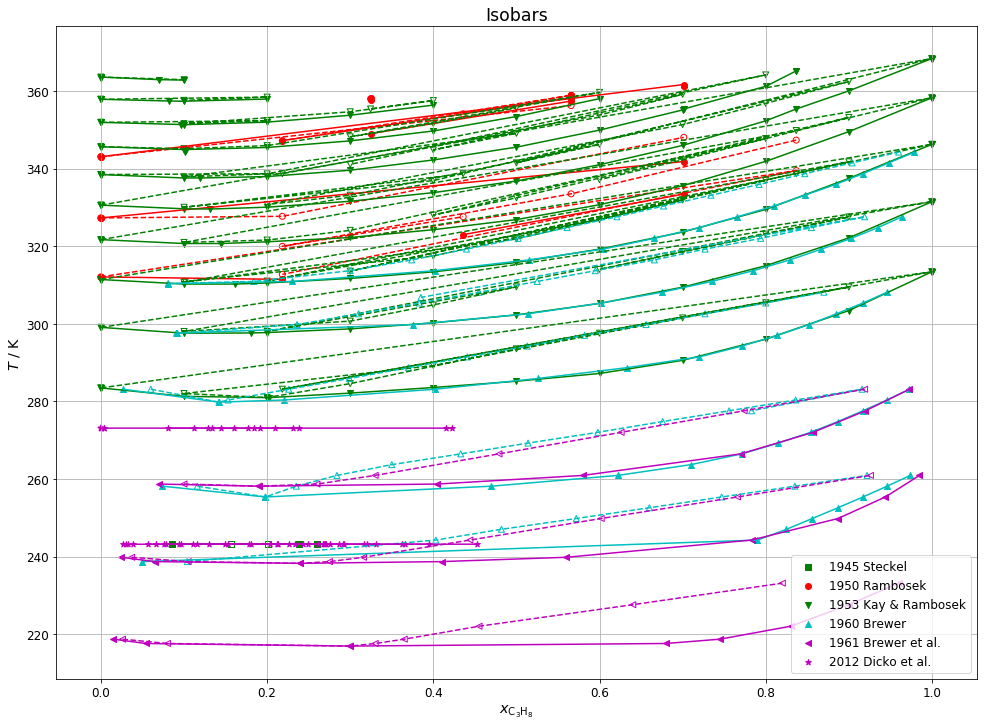

In [69]:
def filter_isobars(df, tol=.01, n=5):
    '''
    Returns a dataframe that contains isobars
    '''
    isobar_df = pd.DataFrame()
    for src in VLE_df[source].unique():
        mask = (VLE_df[source]==src) & (VLE_df[p].notnull()) 
        if rejected in VLE_df.columns:
            mask &= ~VLE_df[rejected].astype(bool)
        subset = VLE_df[mask].sort_values(p)
        i_max = sum(mask)
        i = 0
        cnt = 1
        subset['Set'] = 0
        while i < i_max:
            j = i+1
            while (j < i_max) and ((subset[p].iloc[j] - subset[p].iloc[i] < tol*subset[p].iloc[i]) or (subset[p].iloc[i] == 0)):
                j += 1
            if j - i >= n:
                isobar_df = isobar_df.append(subset.iloc[i:j].sort_values(xC3), ignore_index=True)
                isobar_df.loc[i-j+len(isobar_df):len(isobar_df),'Set'] = cnt
                cnt += 1
            i = j
    
    return isobar_df

isobar_df = filter_isobars(VLE_df)
VLE_plot_set(isobar_df,T, title='Isobars')

## REFPROP
https://trc.nist.gov/refprop/REFPROP.PDF
>REFPROP is an acronym for REFerence fluid PROPerties. This program, developed by the National Institute of
Standards and Technology (NIST), calculates the thermodynamic and transport properties of industrially important
fluids and their mixtures. These properties can be displayed in Tables and Plots through the graphical user interface;
they are also accessible through spreadsheets or user-written applications accessing the REFPROP dll.

>REFPROP is based on the most accurate pure fluid and mixture models currently available. It implements three
models for the thermodynamic properties of pure fluids: equations of state explicit in Helmholtz energy, the modified
Benedict-Webb-Rubin equation of state, and an extended corresponding states (ECS) model. Mixture calculations
employ a model that applies mixing rules to the Helmholtz energy of the mixture components; it uses a departure
function to account for the departure from ideal mixing. Viscosity and thermal conductivity are modeled with either
fluid-specific correlations, an ECS method, or in some cases the friction theory method.


Using the variable `run_refprop`, this worksheet will swap between running the program and using a pickle of the results so that users w/o a license or install have an opportunity to see the comparisons.  We take advantage of the wrappers available at https://github.com/usnistgov/REFPROP-wrappers, installable with the command:
```
pip install ctREFPROP
```

C:\Users\kennethk\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\Users\kennethk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kennethk\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


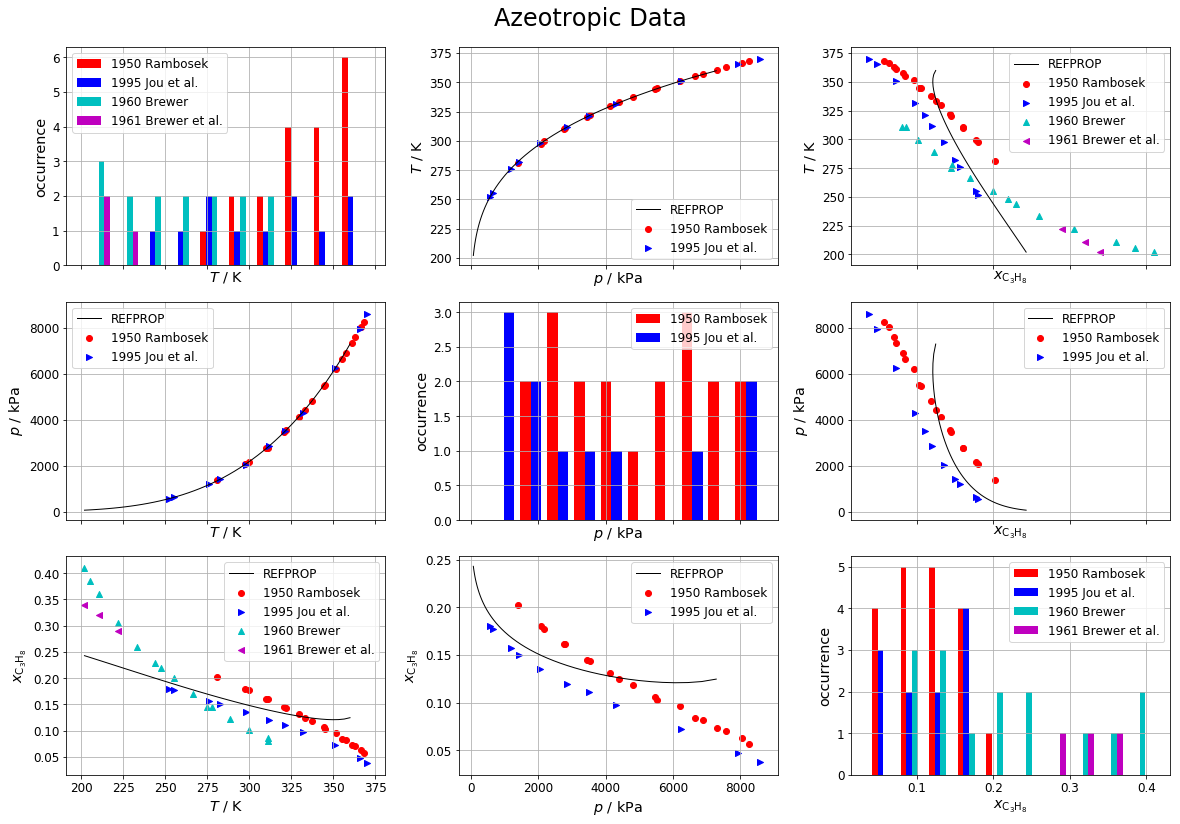

In [20]:
REFPROP_src = 'REFPROP'
plot_kw[REFPROP_src] = {'lw': 1, 'c': 'k', 'label': REFPROP_src}

if run_refprop:
    from ctREFPROP.ctREFPROP import REFPROPFunctionLibrary
    root = r'C:\Program Files (x86)\REFPROP' # Default install directory; customize as necessary <--------
    RP = REFPROPFunctionLibrary(root)
    MOLAR_BASE_SI = RP.GETENUMdll(0,'MOLAR BASE SI').iEnum
    RP.SETPATHdll(root)
    
from scipy import optimize
def azeo_dev(z0, temp):
    return  RP.REFPROPdll('PROPANE;H2S','TQ','P',MOLAR_BASE_SI,0,0,temp,1,[z0,1-z0]+[0.0]*18).x[0] - \
            RP.REFPROPdll('PROPANE;H2S','TQ','P',MOLAR_BASE_SI,0,0,temp,0,[z0,1-z0]+[0.0]*18).y[0]

if run_refprop:
    REFPROP_az_df = pd.DataFrame(columns=[source, rejected, smoothed, T, p, xC3])
    z = optimize.brentq(azeo_dev,0.01,.99, args=(200))
    for temp in np.linspace(az_df[T].min(),az_df[T].max()):
        z = optimize.brentq(azeo_dev,0.85*z,1.20*z, args=(temp))
        ref = RP.REFPROPdll('PROPANE;H2S','TQ','P',MOLAR_BASE_SI,0,0,temp,1,[z,1-z]+[0.0]*18)
        if ref.ierr != 0:
            continue
        press = ref.Output[0] / 1000
        REFPROP_az_df.loc[len(REFPROP_az_df)] = {source:REFPROP_src, rejected: False, smoothed: True, T: temp, p: press, xC3:z}
    with open('REFPROP_az_df.pkl', 'wb') as dbfile: 
        pkl.dump(REFPROP_az_df, dbfile)
else:
    with open('REFPROP_az_df.pkl', 'rb') as dbfile:
        REFPROP_az_df = pkl.load(dbfile)
    
    
plot_grid(az_df.append(REFPROP_az_df), az_df.columns[[1,2,3]], title='Azeotropic Data')

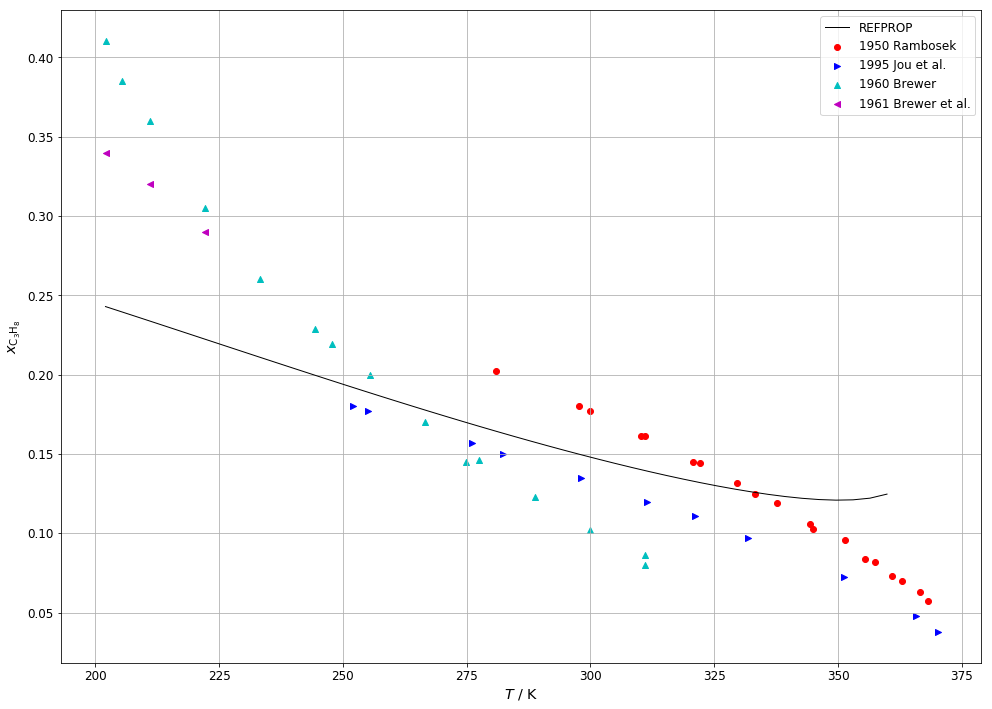

In [21]:
plot_set(az_df.append(REFPROP_az_df),x=T,y=xC3)

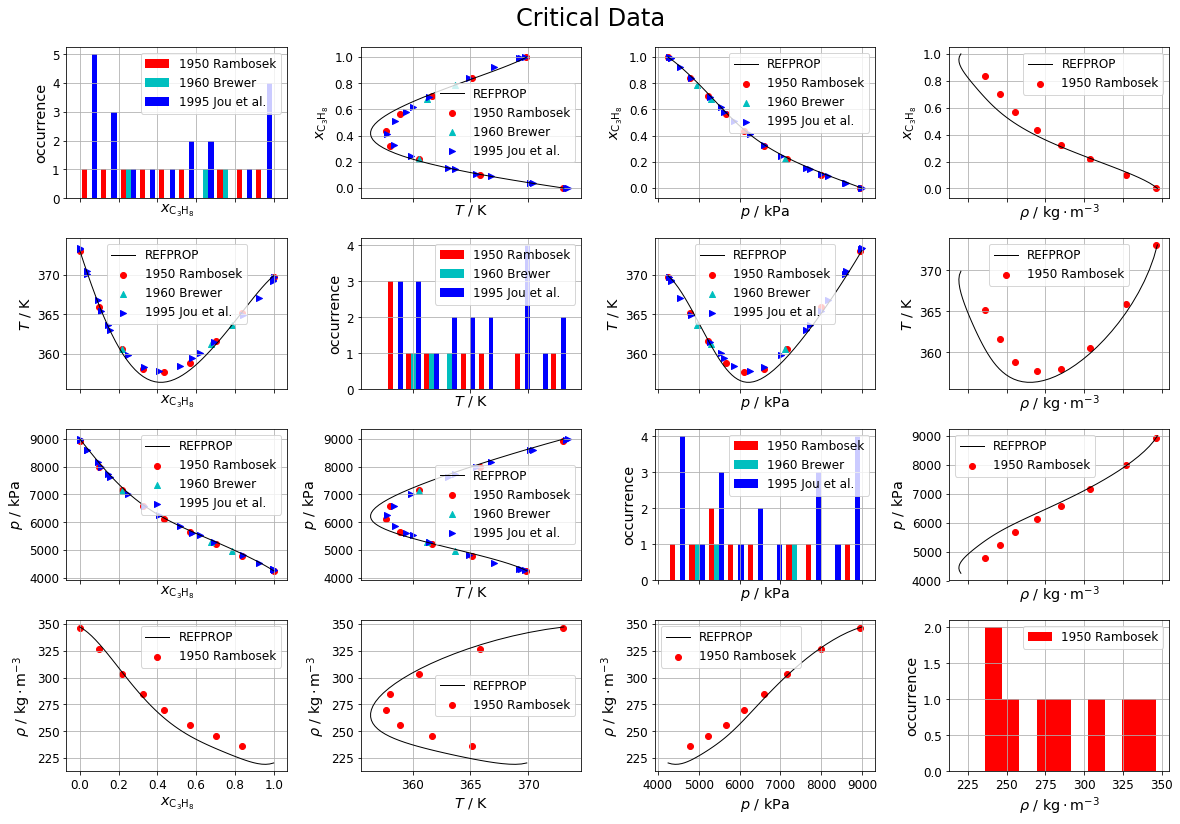

In [22]:
if run_refprop:
    REFPROP_crit_df = pd.DataFrame(columns=[source, rejected, T, p, rho, xC3])
    for z in np.linspace(0,1):
        ref = RP.REFPROPdll('PROPANE;H2S','CRIT','T,P,D,M',MOLAR_BASE_SI,0,0,0,0,[z,1-z]+[0.0]*18)
        if ref.ierr > 0:
            continue
        press = ref.Output[0] / 1000
        REFPROP_crit_df.loc[len(REFPROP_crit_df)] = {source:REFPROP_src, 
                                                     rejected: False, 
                                                     T: ref.Output[0], 
                                                     p: ref.Output[1]/1000,
                                                     rho: ref.Output[2]*ref.Output[3],
                                                     xC3:z}
    with open('REFPROP_crit_df.pkl', 'wb') as dbfile: 
        pkl.dump(REFPROP_crit_df, dbfile)
else:
    with open('REFPROP_crit_df.pkl', 'rb') as dbfile:
        REFPROP_crit_df = pkl.load(dbfile)

plot_grid(crit_df.append(REFPROP_crit_df), crit_df.columns[[1,2,3,4]], title='Critical Data')